In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, alpha_mart, shrink_trunc, stratum_selector, \
    multinomial_selector, get_global_pvalue, simulate_audits, round_robin, ucb_selector
np.random.seed(123456789)

In [9]:
theta = 1/2 
hand_tally = np.concatenate((np.ones(50), np.zeros(50), np.ones(60), np.zeros(40)))
reported_tally = np.concatenate((np.ones(50), np.zeros(50), np.ones(60), np.zeros(40)))
omega = reported_tally - hand_tally
stratum_indicator = np.concatenate((np.ones(100), 2*np.ones(100)))
u_A = np.ones(2)

A_c = [np.mean(reported_tally[stratum_indicator == 1]), np.mean(reported_tally[stratum_indicator == 1])]
strata = [u_A[0] - omega[stratum_indicator == 1], u_A[1] - omega[stratum_indicator == 2]]

In [13]:
rule = round_robin
shuffled_1 = np.random.permutation(strata[0])
shuffled_2 = np.random.permutation(strata[1])
N = np.concatenate((np.array([len(shuffled_1)]), np.array([len(shuffled_2)])))
w = N/sum(N)
epsilon = 1 / (2*np.max(N))
raw_theta_1_grid = np.arange(epsilon, u_A[0] - epsilon, epsilon) #sequence from epsilon to u[0] - epsilon
raw_theta_2_grid = (1/2 - w[0] * raw_theta_1_grid) / w[1]
theta_1_grid = raw_theta_1_grid + u_A[0] - A_c[0]
theta_2_grid = raw_theta_2_grid + u_A[1] - A_c[1]

strata_matrix = np.zeros((len(shuffled_1) + len(shuffled_2) - 1, len(theta_1_grid)))
intersection_marts = np.zeros((len(shuffled_1) + len(shuffled_2), len(theta_1_grid)))
for i in range(len(theta_1_grid)):
    mart_1, mu_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = u_A[0], f = .01, u = 2*u_A[0])
    mart_2, mu_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = u_A[1], f = .01, u = 2*u_A[1])
    if rule == ucb_selector:
        lsm_marts_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = theta_1_grid[i]/2, f = .01, u = 2*u_A[0], alternative = "lower")[0]
        lsm_marts_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = theta_2_grid[i]/2, f = .01, u = 2*u_A[1], alternative = "lower")[0]
        lsm_marts = [lsm_marts_1, lsm_marts_2]
    else:
        lsm_marts = None
    strata_matrix[:,i], intersection_marts[:,i] = stratum_selector(
        marts = [mart_1, mart_2],
        mu = [mu_1, mu_2],
        u = 2*u_A,
        lower_sided_marts = lsm_marts,
        rule = rule)
null_index = np.argmin(intersection_marts, axis = 1)
#stratum_selections = strata_matrix[1:sum(N), null_index]
#minimized_martingale = intersection_marts[1:sum(N), null_index]
minimized_martingale = np.ones(sum(N))
stratum_selections = np.ones(sum(N) - 1) * np.inf
for i in np.arange(sum(N) - 1):
    minimized_martingale[i] = intersection_marts[i,null_index[i]]
    stratum_selections[i] = strata_matrix[i,null_index[i]]
p_values = 1 / np.maximum(1, minimized_martingale)
null_selections = raw_theta_1_grid[null_index]
p_values, stratum_selections, null_selections

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  1.,  0.,  

In [27]:
theta_1_grid

array([0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 , 0.545,
       0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585, 0.59 ,
       0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 , 0.635,
       0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675, 0.68 ,
       0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 , 0.725,
       0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 ,
       0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 , 0.815,
       0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855, 0.86 ,
       0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.905,
       0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945, 0.95 ,
       0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995,
       1.   , 1.005, 1.01 , 1.015, 1.02 , 1.025, 1.03 , 1.035, 1.04 ,
       1.045, 1.05 , 1.055, 1.06 , 1.065, 1.07 , 1.075, 1.08 , 1.085,
       1.09 , 1.095, 1.1  , 1.105, 1.11 , 1.115, 1.12 , 1.125, 1.13 ,
       1.135, 1.14 ,

In [22]:
shuffled_2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
p_value, stratum_selections, null_selections = get_global_pvalue(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = multinomial_selector)
p_value, stratum_selections, null_selections

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([ 1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  

In [4]:
stopping_times_roundrobin = simulate_audits(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = round_robin, 
    n_sims = 30, 
    alpha = .05)
stopping_times_multinomial = simulate_audits(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = multinomial_selector, 
    n_sims = 30, 
    alpha = .05)

In [5]:
#something seems wrong here...
[np.mean(stopping_times_roundrobin), 
 np.mean(stopping_times_multinomial), 
 np.quantile(stopping_times_roundrobin, q = 0.9),
 np.quantile(stopping_times_multinomial, q = 0.9)]




/Users/Jake/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


[inf, inf, nan, nan]

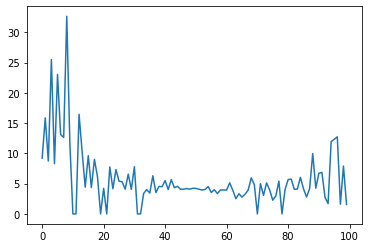

In [5]:
# topography of the P-value of the intersection null at a few sample sizes
rule = ucb_selector
#rule = multinomial_selector
#rule = round_robin

shuffled_1 = np.random.permutation(strata[0])
shuffled_2 = np.random.permutation(strata[1])
N = np.concatenate((np.array([len(shuffled_1)]), np.array([len(shuffled_2)])))
w = N/sum(N)
epsilon = 1 / (2*np.max(N))
raw_theta_1_grid = np.arange(epsilon, u_A[0] - epsilon, epsilon) #sequence from epsilon to u[0] - epsilon
raw_theta_2_grid = (1/2 - w[0] * raw_theta_1_grid) / w[1]
theta_1_grid = raw_theta_1_grid + u_A[0] - A_c[0]
theta_2_grid = raw_theta_2_grid + u_A[1] - A_c[1]

strata_matrix = np.zeros((len(shuffled_1) + len(shuffled_2) - 1, len(theta_1_grid)))
intersection_marts = np.zeros((len(shuffled_1) + len(shuffled_2), len(theta_1_grid)))
for i in range(len(theta_1_grid)):
    mart_1, mu_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = u_A[0], f = .01, u = 2*u_A[0])
    mart_2, mu_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = u_A[1], f = .01, u = 2*u_A[1])
    if rule == ucb_selector:
        lsm_marts_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = theta_1_grid[i]/2, f = .01, u = 2*u_A[0], alternative = "lower")[0]
        lsm_marts_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = theta_2_grid[i]/2, f = .01, u = 2*u_A[1], alternative = "lower")[0]
        lsm_marts = [lsm_marts_1, lsm_marts_2]
    else:
        lsm_marts = None
    strata_matrix[:,i], intersection_marts[:,i] = stratum_selector(
        marts = [mart_1, mart_2],
        mu = [mu_1, mu_2],
        u = 2*u_A,
        lower_sided_marts = lsm_marts,
        rule = rule)
null_index = np.argmin(intersection_marts, axis = 1)
#stratum_selections = strata_matrix[1:sum(N), null_index]
#minimized_martingale = intersection_marts[1:sum(N), null_index]
minimized_martingale = np.ones(sum(N))
stratum_selections = np.ones(sum(N) - 1) * np.inf
for i in np.arange(sum(N) - 1):
    minimized_martingale[i] = intersection_marts[i,null_index[i]]
    stratum_selections[i] = strata_matrix[i,null_index[i]]
maximized_p_values = 1 / np.maximum(1, minimized_martingale)
plt.plot(intersection_marts[10,50:150])

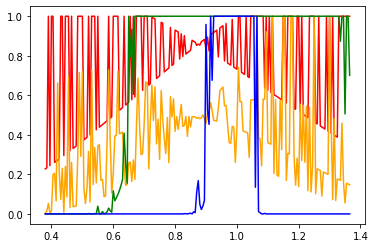

In [6]:
#the below plots are smooth if the rule is round robin, and not at all smooth if it is the intersection martingale
#it might have to do with the fact that different samples are used for every value of theta_1_grid...
#this doesn't happen in the R code: the contours of the intersection martingale are smooth,
#but in that implementation there is no auxiliary randomness
thresholded_marts = intersection_marts
thresholded_marts[intersection_marts < 1] = 1
all_p_values = 1/thresholded_marts
plt.plot(theta_1_grid, all_p_values[1,:], color = 'red')
plt.plot(theta_1_grid, all_p_values[5,:], color = 'orange')
plt.plot(theta_1_grid, all_p_values[30,:], color = 'green')
plt.plot(theta_1_grid, all_p_values[100,:], color = 'blue')